McSAS-3; notebook version
==
v1: the model and measured intensity are now plain dictionaries instead of Pandas DataFrames. This speeds up the method a lot, by about a factor of 20.

v2: a test has been done to see if it also helps to make the parameterSet a plain dictionary instead of a pandas DataFrame. result: minimal gains of less than a few percent. This effort is stored in McSAS_v2 but reverted. 

v3: back to the original variant with the parameterSet in a DataFrame. This is easier to work with internally and as a result. 

v4: more clean-up and trying Paul Kienzle's even more core model approach (since we're not using polydispersity options on the parameters)

v5: no luck finding those more core approaches, even forcing ocl calculations, no speed improvement was noticed. Anyway, let's 2D fit (because why start with 1D fits?)

In [1]:
# import all the necessary bits and bobs

import h5py, sys
import numpy as np
import pandas
import scipy
import multiprocessing

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

# change this one to whereever you have the sasmodels installed:
sys.path.append('/Users/brian/Code/sasmodels/')
import sasmodels
import sasmodels.core
import sasmodels.direct_model

In [2]:
# show me all the available models, 1D and 1D+2D

print("\n \n   1D-only SasModel Models:\n")

for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if not modelInfo.parameters.has_2d:
        print("{} is available only in 1D".format(modelInfo.id))

print("\n \n   2D- and 1D- SasModel Models:\n")
for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if modelInfo.parameters.has_2d:
        print("{} is available in 2D".format(modelInfo.id))


 
   1D-only SasModel Models:

adsorbed_layer is available only in 1D
be_polyelectrolyte is available only in 1D
binary_hard_sphere is available only in 1D
broad_peak is available only in 1D
core_multi_shell is available only in 1D
core_shell_sphere is available only in 1D
correlation_length is available only in 1D
dab is available only in 1D
flexible_cylinder is available only in 1D
flexible_cylinder_elliptical is available only in 1D
fractal is available only in 1D
fractal_core_shell is available only in 1D
fuzzy_sphere is available only in 1D
gauss_lorentz_gel is available only in 1D
gaussian_peak is available only in 1D
gel_fit is available only in 1D
guinier is available only in 1D
guinier_porod is available only in 1D
hardsphere is available only in 1D
hayter_msa is available only in 1D
hollow_rectangular_prism_thin_walls is available only in 1D
lamellar is available only in 1D
lamellar_hg is available only in 1D
lamellar_hg_stack_caille is available only in 1D
lamellar_stack_ca

Class definitions:
--

We define several classes here:
  - optimizeScalingAndBackground: takes care of the calculation of the reduced chi-squared value, after a least-squares optimization for the scaling and background factors.
  - McModel: extends the SasModel with information on the parameter set and methods for calculating a total scattering intensity from multiple contributions. It also tracks parameter bounds, random generators and picks.
  - McOpt: contains mostly settings related to the optimization process. Also keeps track of the contribution to optimize.
  - McCore: Contains the methods required to do the optimization. 
  

In [3]:
class optimizeScalingAndBackground(object):
    """small class derived from the McSAS mcsas/backgroundscalingfit.py class, 
    quickly provides an optimized scaling and background value for two datasets.
    
    TODO (maybe): include a $I \propto Q^{-4}$ background contribution? If so, Q should be
    available to this class.......
    
    inputs:
    *measDataI*: numpy array of measured intensities
    *measDataISigma*: associated uncertainties
    *modelDataI*: array of model intensities. 
    *x0* (optional): two-element tuple with initial guess for scaling and background
    *xBounds* (optional): constraints to the optimization, speeds up when appropriate constraints are given

    Returns:
    :x: length 2 ndarray with optimized scaling parameter and background parameter
    :cs: final reduced chi-squared 
    
    Usage example: 
    >>> o = optimizeScalingAndBackground(measDataI, measDataISigma)
    >>> xOpt, rcs = o.match(modelDataI) 
    """
    measDataI = None
    measDataISigma = None
    xBounds = None
    
    def __init__(self, measDataI = None, measDataISigma = None, xBounds = None):
        self.measDataI = measDataI
        self.measDataISigma = measDataISigma
        self.validate()
        if xBounds is None:
            self.xBounds = [[0, None], 
                            [-self.measDataI.mean(), self.measDataI.mean()]]

    def validate(self):
        # checks input
        assert(not any(np.isnan(self.measDataI)))
        assert(not any(np.isinf(self.measDataI)))
        assert(not any(np.isnan(self.measDataISigma)))
        assert(not any(np.isinf(self.measDataISigma)))
        assert(any(np.isfinite(self.measDataISigma)))
        assert(any(np.isfinite(self.measDataISigma)))
        assert(self.measDataI.size != 0)
        assert(self.measDataI.shape == self.measDataISigma.shape)
        assert(self.measDataI.ndim == 1)
        
    @staticmethod
    def optFunc(sc, measDataI, measDataISigma, modelDataI):
        # reduced chi-square; normalized by uncertainty. 
        cs = sum((
            (measDataI - (modelDataI * sc[0] + sc[1]))/measDataISigma)**2
        ) / measDataI.size
        return cs
    
    def match(self, modelDataI, x0 = None):
        if x0 is None: # optional argument with starting guess..
            # some initial guess
            x0 = np.array([self.measDataI.mean() / modelDataI.mean(), self.measDataI.min()])
        # adapt bounds to modelData:
        # self._xBounds[0][1] /= modelDataI.mean()
        opt = scipy.optimize.minimize(self.optFunc, 
                                x0, 
                                args = (self.measDataI, self.measDataISigma, modelDataI), 
                                # method = "TNC", 
                                bounds = self.xBounds)
        return opt["x"], opt["fun"]
    

In [4]:
class McModel(object):
    """
    Specifies the fit parameter details and contains random pickers. 
    requires:
    fitParameterLimits: dict of value pairs {"param1": (lower, upper), ... } for fit parameters
    staticParameters: dict of parameter-value pairs to keep static during the fit. 
    """
    # import np.random.uniform 
    
    func = None # SasModels model instance
    kernel = None # SasModels kernel pointer
    parameterSet = None # pandas dataFrame of length nContrib, with column names of parameters
    staticParameters = None # dictionary of static parameter-value pairs during MC optimization
    pickParameters = None  # dict of values with new random picks, named by parameter names
    pickIndex = None # int showing the running number of the current contribution being tested
    fitParameterLimits = None # dict of value pairs (tuples) *for fit parameters only* with lower, upper limits for the random function generator, named by parameter names 
    randomGenerators = None # dict with random value generators 
    volumes = None # array of volumes for each model contribution, calculated during execution
    seed = None # random generator seed, should vary for parallel execution
    
    def fitKeys(self):
        return [key for key in self.fitParameterLimits]
    
    def __init__(self, fitParameterLimits = None, staticParameters = None, func = None, seed = 12345):
        self.func = func
        self.fitParameterLimits = fitParameterLimits
        self.staticParameters = staticParameters
        self.seed = seed

    def initialize(self, nContrib):
        # after nContrib is known, this can be exectued.
        self.randomGenerators = dict.fromkeys(
            [key for key in self.fitParameterLimits], np.random.RandomState(self.seed).uniform)
        self.parameterSet = pandas.DataFrame(
            index = range(nContrib), columns = self.fitKeys())
        self.fillParameterSet()
       
    def pick(self):
        """pick new random model parameter"""
        self.pickParameters = self.generateRandomParameterValues()

    def generateRandomParameterValues(self):
        """to be depreciated as soon as models can generate their own..."""
        # initialize dict with parameter-value pairs defaulting to None
        returnDict = dict.fromkeys([key for key in self.fitParameterLimits])
        # fill:
        for parName in self.fitParameterLimits.keys():
            # can be replaced by a loop over iteritems:
            (upper, lower) = self.fitParameterLimits[parName]            
            returnDict[parName] = self.randomGenerators[parName](upper, lower)
        return returnDict
    
    def fillParameterSet(self):
        """fills the model parameter values with random values"""
        for contribi in range(self.parameterSet.shape[0]):
            # can be improved with a list comprehension, but this only executes once..
            self.parameterSet.loc[contribi] = self.generateRandomParameterValues()
    

In [5]:
class McOpt(object):
    """Class to store optimization settings and keep track of running variables"""
    x0 = None         # continually updated new guess for total scaling, background values.
    testX0 = None     # X0 if test is accepted.
    gof = None        # continually updated gof value
    weighting = 0.5   # NOT USED, set to default = volume-weighted.  volume-weighting / compensation factor for the contributions 
    nContrib = None   # also copied in McParams
    nRep = None       # number of repeated independent optimizations to calculate population statistics over
    maxIter = None    # maximum steps before fail
    maxAccept = None  # maximum accepted before valid return
    convCrit = None   # reduced chi-square before valid return
    step = None       # number of iteration steps
    accepted = None   # number of accepted picks
    modelI = None     # internal, will be filled later
    testModelI = None # internal, updated intensity after replacing with pick
    testModelV = None # volume of test object, optionally used for weighted histogramming later on.
    
    def __init__(self, nContrib = 300, maxIter = 100000, maxAccept = np.inf, convCrit = 1, nRep = 4):
        self.nContrib = int(nContrib)
        self.maxIter = maxIter
        self.maxAccept = maxAccept
        self.convCrit = convCrit
        self.x0 = np.array([1, 0])
        
    def contribIndex(self):
        """ returns current index of contribution being optimized """
        return self.step % self.nContrib
    



In [6]:
class McCore(object): 
    """
    The core of the MC procedure. Strict requirements on input include:
    modelFunc: SasModels function
    measData: measurement data dictionary with Q, I, ISigma containing arrays
    pickParameters: dict of values with new random picks, named by parameter names
    modelParameterLimits: dict of value pairs (tuples) with random pick bounds, named by parameter names 
    x0: continually updated new guess for total scaling, background values. 
    weighting: volume-weighting / compensation factor for the contributions
    nContrib: number of contributions
    """
    import scipy.optimize 
    
    _measData = None  # measurement data dict with entries for Q, I, ISigma
    _model = None     # instance of McModel
    _opt = None       # instance of McOpt
    _OSB = None       # optimizeScalingAndBackground instance for this data
    
    def __init__(self, 
                 measData = None, 
                 model = None, 
                 opt = None,
                ):
        
        self._model = model 
        self._measData = measData 
        self._opt = opt    # McOpt instance
        self._opt.nContrib # pass on this important parameter
        self._opt.step = 0 # number of iteration steps
        self._opt.accepted = 0 # number of accepted iterations
        self._OSB = optimizeScalingAndBackground(measData["I"], measData["ISigma"])

        self.initModel()   # initialize SasView model
        self._opt.gof = self.evaluate() # calculate initial GOF measure

    def initModel(self):
        # sets up parameters set with nContrib contributions:
        self._model.initialize(self._opt.nContrib) 
        # set default parameters:
        self._model.func.info.parameters.defaults.update(self._model.staticParameters)
        # generate kernel
        self._model.kernel = self._model.func.make_kernel(self._measData["Q"])
        # calculate scattering intensity by combining intensities from all contributions
        self.initModelI()
    
    def load(self):
        """loads the configuration and set-up from the extended NXcanSAS file"""
        # not implemented yet
        pass

    def calcModelI(self, parameters):
        """calculates the intensity and volume of a particular set of parameters"""
        return sasmodels.direct_model.call_kernel(
                self._model.kernel, 
                parameters
            )
    
    def returnModelV(self):
        """
        Returns the volume of the last kernel calculation. 
        Has to be run directly after calculation. May be replaced by more appropriate 
        SasModels function calls once available. 
        """
        return self._model.kernel.result[self._model.kernel.q_input.nq]
    
    def initModelI(self):
        """calculate the total intensity from all contributions"""
        # set initial shape:
        I = self.calcModelI( 
            self._model.parameterSet.loc[0].to_dict()
        ) 
        # zero-out all previously stored values for intensity and volume
        self._opt.modelI = np.zeros(I.shape)
        self._model.volumes = np.zeros(self._opt.nContrib)
        # add the intensity of every contribution
        for contribi in range(self._opt.nContrib):
            I = self.calcModelI( 
                self._model.parameterSet.loc[contribi].to_dict()
            ) 
            V = self.returnModelV()
            # intensity is added, normalized by number of contributions. 
            # volume normalization is already done in SasModels (!), so we have volume-weighted intensities from there...
            self._opt.modelI += I / self._opt.nContrib # / (self._opt.nContrib * V)
            # we store the volumes anyway since we may want to use them later for showing alternatives of number-weighted, or volume-squared weighted histograms
            self._model.volumes[contribi] = self.returnModelV()
    
    def evaluate(self, testData = None): # takes 20 ms! 
        """scale and calculate goodness-of-fit (GOF) from all contributions"""

        if testData is None:
            testData = self._opt.modelI
            
        # this function takes quite a while:
        self._opt.testX0, gof = self._OSB.match(testData, self._opt.x0)
        return gof
    
    def reEvaluate(self):
        """replace single contribution with new contribution, recalculate intensity and GOF"""

        # calculate old intensity to subtract:
        Iold = self.calcModelI( 
            self._model.parameterSet.loc[self._opt.contribIndex()].to_dict()
        ) 
        # not needed:
        # Vold = self.returnModelV() # = self._model.volumes[self._opt.contribIndex()]
        
        # calculate new intensity to add:
        Ipick = self.calcModelI( self._model.pickParameters ) 
        Vpick = self.returnModelV()
        
        # remove intensity from contribi from modelI
        # add intensity from Pick
        self._opt.testModelI = self._opt.modelI + (Ipick - 
                                Iold )/ self._opt.nContrib
        
        # store pick volume in temporary location
        self._opt.testModelV = Vpick
        # recalculate reduced chi-squared for this option
        return self.evaluate(self._opt.testModelI)
    
    def reject(self):
        """reject pick"""
        # nothing to do. Can be used to fish out a running rejection/acceptance ratio later
        pass
    
    def accept(self):
        """accept pick"""
        # store parameters of accepted pick:
        self._model.parameterSet.loc[self._opt.contribIndex()] = self._model.pickParameters
        # store calculated intensity as new total intensity:
        self._opt.modelI = self._opt.testModelI
        # store new pick volume to the set of volumes:
        self._model.volumes[self._opt.contribIndex()] = self._opt.testModelV
        # store latest scaling and background values as new initial guess:
        self._opt.x0 = self._opt.testX0
        # add one to the accepted moves counter:
        self._opt.accepted += 1
    
    def iterate(self):
        """pick, re-evaluate and accept/reject"""
        # pick new model parameters:
        self._model.pick() # 3 µs
        # calculate GOF for the new total set:
        newGof = self.reEvaluate() # 2 ms
        # if this is an improvement:
        if (newGof < self._opt.gof):
            # accept the move:
            self.accept() # 500 µs
            # and store the new GOF as current:
            self._opt.gof = newGof           
        # increment step counter in either case: 
        self._opt.step += 1
    
    def optimize(self):
        """iterate until target GOF or maxiter reached"""
        print("Optimization started")
        print("chiSqr: {}, N accepted: {} / {}"
              .format(self._opt.gof, self._opt.accepted, self._opt.step))       

        # continue optimizing until we reach any of these targets:
        while ((self._opt.accepted < self._opt.maxAccept) & # max accepted moves
               (self._opt.step < self._opt.maxIter) &       # max number of tries
               (self._opt.gof > self._opt.convCrit)):       # convergence criterion reached
            self.iterate()
            # show me every 1000 steps where you are in the optimization:
            if (self._opt.step % 1000 == 1):
                print("chiSqr: {}, N accepted: {} / {}"
                      .format(self._opt.gof, self._opt.accepted, self._opt.step))
                
    def run(self):
        """runs the full sequence: multiple repetitions of optimizations, to be parallelized"""
        # NOT FINISHED YET, individual optimizations are not yet stored(!)
        for rep in range(self._opt.nRep):
            self.optimize()
            
    def store(self):
        """stores the resulting model parameter-set in the NXcanSAS object, ready for histogramming"""
        # not finished
        pass

1D Tests
== 

The 1D tests load the standard McSAS Quickstartdemo dataset, which is a simulated dataset from a trimodal distribution. 

Speed of a single optimization (~6s) is close to that of McSAS (~6s). After dicking around with the 
optimizeScalingAndBackground fitting bounds, it's increased to 17s.. 

In [7]:
# ok, let's try a more gentle optimization using 1D data :). 
# test with directly imported data

# import data using Pandas
qs = pandas.read_csv("quickstartdemo1.csv", delimiter = ';', header = None, names = ["Q", "I", "ISigma"])
measData = qs.to_dict(orient = "list") # lazy-conversion to dict
measData["Q"] = [np.array(measData["Q"])] # needs to be a list with [Q] or [Qx,Qy]. Q always one-dimensional
measData["I"] = np.array(measData["I"])   # measured intensity, shape must match Q
measData["ISigma"] = np.array(measData["ISigma"]) # uncertainties on the intensiy

import time # I need more time

model = sasmodels.core.load_model('sphere', dtype = "fast") # can't get OpenCV to speed things up...
# kernel = model.make_kernel(measData["Q"])

# track time
t = time.time()

# initialize optimization settings:
mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
# make me a model:
mcmod = McModel(
    func = model, seed = 12,
    fitParameterLimits = {"radius": (3, 315)}, 
    staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })
# tell me the time
print("param prep: {}".format(time.time() - t))
# initialize the core with the model and the optimization settings:
mc = McCore(measData, model = mcmod, opt = mcopt)
# tell me the time
print("McCore prep: {}".format(time.time() - t))
# do one iteration step
mc.iterate()
# tell me the time again...
print("Iterate: {}".format(time.time() - t))
# where are we now:
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
mc.optimize()
mc._model.kernel.release()
print("Final mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))

param prep: 0.0002548694610595703
McCore prep: 0.6511569023132324
Iterate: 0.6588249206542969
mc.chisqr: 3893.100413326442, n accepted: 0
Optimization started
chiSqr: 3893.100413326442, N accepted: 0 / 1
chiSqr: 144.73295778764015, N accepted: 326 / 1001
chiSqr: 7.865942073586326, N accepted: 495 / 2001
chiSqr: 1.8092845083060056, N accepted: 562 / 3001
chiSqr: 1.176541664822757, N accepted: 589 / 4001
chiSqr: 1.0588460947702962, N accepted: 603 / 5001
Final mc.chisqr: 0.973231025703538, n accepted: 608


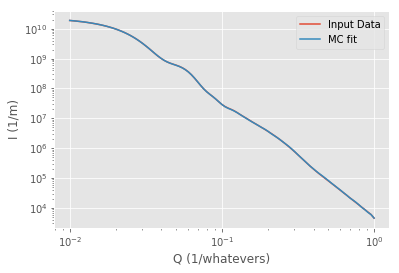

In [8]:
# plot the intensity match:

plt.plot(measData["Q"][0], measData["I"], label = "Input Data")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Q (1/whatevers)")
plt.ylabel("I (1/m)")
plt.plot(measData["Q"][0], mc._opt.modelI * mc._opt.x0[0] + mc._opt.x0[1], label = "MC fit")
plt.legend(loc = 0)

(array([ 2.,  7., 17.,  8.,  3.,  0.,  1.,  0.,  1.,  3.,  6.,  9., 10.,
        10., 14., 17., 16., 14.,  8.,  6.,  4.,  5.,  3.,  0.,  1.,  0.,
         0.,  4.,  1.,  2.,  6.,  8., 12., 11., 17., 13., 15., 10., 14.,
         7.,  7.,  1.,  3.,  0.,  2.,  1.,  0.,  0.,  0.,  1.]),
 array([  3.04505723,   5.84838872,   8.6517202 ,  11.45505168,
         14.25838316,  17.06171465,  19.86504613,  22.66837761,
         25.47170909,  28.27504058,  31.07837206,  33.88170354,
         36.68503502,  39.48836651,  42.29169799,  45.09502947,
         47.89836095,  50.70169244,  53.50502392,  56.3083554 ,
         59.11168688,  61.91501836,  64.71834985,  67.52168133,
         70.32501281,  73.12834429,  75.93167578,  78.73500726,
         81.53833874,  84.34167022,  87.14500171,  89.94833319,
         92.75166467,  95.55499615,  98.35832764, 101.16165912,
        103.9649906 , 106.76832208, 109.57165357, 112.37498505,
        115.17831653, 117.98164801, 120.7849795 , 123.58831098,
        126.

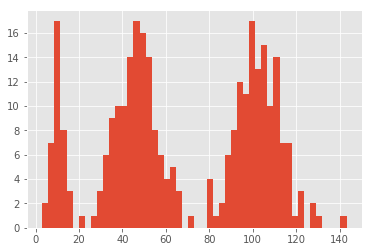

In [9]:
# apparently, the SasModels are already volume-weighted!
# plot the size histogram, linear X-axis for now..
plt.hist(list(mc._model.parameterSet["radius"]), bins = 50, log = False)

Until here, everything works...
==

(but check out the 2D data fitting below, which partially works!)

In [10]:
# all separate instances, but producing the same result. random needs seed?
# model = sasmodels.core.load_model('sphere', dtype = "fast")


def runit(seed):
    # # it runs with a single kernel, but I'm a bir afraid of cross-talk between the instances and volume calculations..
    model = sasmodels.core.load_model('sphere', dtype = "fast", platform = "ocl")
    # kernel = model.make_kernel(measData["Q"])
    mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
    mcpar = McModel(
        func = model, seed = seed,
        fitParameterLimits = {"radius": (3, 315)}, 
        staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })
    mc = McCore(measData, model = mcpar, opt = mcopt)
    mc._OSB.xBounds = ([0, 1e7], [-1e4, 1e4])
    mc.optimize()
    mc._model.kernel.release()
    return mc._model.parameterSet

runit(1)
# Pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# mapParam = [i for i in range(int(10))]
# rawData = Pool.map(runit, mapParam) 

Optimization started
chiSqr: 4161.854578255158, N accepted: 0 / 0
chiSqr: 4161.854578255158, N accepted: 0 / 1
chiSqr: 141.17766238578335, N accepted: 362 / 1001
chiSqr: 15.199812210469265, N accepted: 516 / 2001
chiSqr: 2.8216735723063766, N accepted: 608 / 3001
chiSqr: 1.3046053720971629, N accepted: 645 / 4001


,radius
0,47.6752
1,63.6512
2,26.4102
3,75.2911
4,48.7878
5,31.8096
6,6.61595
7,121.487
8,98.903
9,100.428


In [17]:
# Paul suggested doing it this way.. doesn't work..

sasmodels.direct_model.DirectModel
kernel1 = sasmodels.direct_model.DirectModel(measData["Q"], model)

AttributeError: 'list' object has no attribute 'x'

In [18]:
# continuation of Paul's suggestions:

parameters = kernel.info.parameters
mesh = [(np.nan, np.nan, 1.0) for p in parameters.call_parameters]
call_details, values, magnetic = sasmodels.direct_model.make_kernel_args(kernel, mesh)
call_details.show(values)

NameError: name 'kernel' is not defined

In [27]:
# continuation of Paul's suggestions:
# Set up parameter vectors with NaN placeholders for the parameter set
parameters = kernel.info.parameters
mesh = [(NaN, NaN, 1.0) for p in parameters.call_parameters]
call_details, values, magnetic = make_kernel_args(kernel, mesh)
call_details.show(values)

# generate views on the values vector to make it easier to assign parameter sets
value_vec = values[0:parameters.nvalues]
dist_vec = values[parameters.nvalues:parameters.nvalues + call_details.num_weights]

# Loop over the monte carlo parameter sets, calling the kernel for each one.
Iq = np.zero(kernel.q_input.nq)
for parameter_set in monte_carlo(n):
   # scale, background in values[0], values[1]
   value_vec[:] = parameter_set
   dist_vec[:] = parameter_set
   Iq += kernel(call_details, values, cutoff, magnetic)
Iq /= n


In [9]:
#openCL?

import pyopencl
%load_ext pyopencl.ipython_ext

In [22]:
# all separate instances, but producing the same result. random needs seed?
# model = sasmodels.core.load_model('sphere', dtype = "fast")

# no longer works??? somehow things get stuck in a wait loop now. 
model = sasmodels.core.load_model('sphere', dtype = "fast", platform = "ocl")

def runit(seed):
    # # it runs with a single kernel, but I'm a bir afraid of cross-talk between the instances and volume calculations..
    # kernel = model.make_kernel(measData["Q"])
    mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
    mcpar = McModel(
        func = model, seed = seed,
        fitParameterLimits = {"radius": (3, 315)}, 
        staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })
    mc = McCore(measData, model = mcpar, opt = mcopt)
    mc.optimize()
    self._model.kernel.release()
    return mc._model.parameterSet

Pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
mapParam = [i for i in range(int(10))]
rawData = Pool.map(runit, mapParam) 

Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", 

KeyboardInterrupt: 

In [13]:
t = time.time()
for n in range(1000):
    mc.iterate()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("Iterate: {} s".format(time.time() - t))

mc.chisqr: 0.8696311968213971, n accepted: 621
Iterate: 3.261826276779175 s


2D Test
-- 

For this test, we use one of Qais' datasets. This is a dataset from magnetically-oriented pearl strings. 

In [13]:
# test with directly imported data
with h5py.File("20180503_13_raw_expanded_stacked_processed_180507_125408.nxs", 'r') as h5f:
    I = h5f['/entry/result/data'].value.squeeze()
    ISigma = h5f['/entry/result/errors'].value.squeeze()
    Qx = h5f['/entry/result/Q-space (inverse Angstrom)'].value
    Qy = h5f['/entry/result/Q-space (inverse Angstrom)1'].value
with h5py.File("Mask conf 3.nxs", 'r') as h5f:
    mask = h5f['/entry/mask/mask'].value.squeeze()
newMask = ((I<-500) | mask)
newMask = newMask.astype(bool)

posNeg = np.sign(np.diff(Qx))
posNeg = np.append(posNeg, posNeg[-1])
Qx = Qx * posNeg

posNeg = np.sign(np.diff(Qy))
posNeg = np.append(posNeg, posNeg[-1])
Qy = Qy * posNeg

Q0 = Qx[:, np.newaxis] + 0 * Qy[np.newaxis, :]
Q1 = 0 * Qx[:, np.newaxis] + Qy[np.newaxis, :]

a0l, a0h, a1l, a1h = 300, 500, 400, 600
# a0l, a0h, a1l, a1h = 200, 600, 300, 700
measData = dict()
measData["IOrig"] = (I / np.invert(newMask))[a0l: a0h, a1l: a1h]
measData["kansas"] = measData["IOrig"].shape
measData["IOrig"] = np.reshape(measData["IOrig"], measData["IOrig"].size)
measData["ISigmaOrig"] = (ISigma / np.invert(newMask))[a0l: a0h, a1l: a1h]
measData["ISigmaOrig"] = np.reshape(measData["ISigmaOrig"], measData["ISigmaOrig"].size)
measData["QOrig"] = [
    np.reshape((Q0 / np.invert(newMask))[a0l: a0h, a1l: a1h], measData["ISigmaOrig"].size),
    np.reshape((Q1 / np.invert(newMask))[a0l: a0h, a1l: a1h], measData["ISigmaOrig"].size)]

bArr = np.invert((np.isinf(measData["IOrig"])|(measData["ISigmaOrig"] == 0)))
measData["I"] = measData["IOrig"][bArr]
measData["ISigma"] = measData["ISigmaOrig"][bArr]
measData["Q"] = [measData["QOrig"][0][bArr], measData["QOrig"][1][bArr]]

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [14]:
import time
nContrib = 300

model = sasmodels.core.load_model('ellipsoid', dtype = "fast")
kernel = model.make_kernel(measData["Q"])

t = time.time()
mcopt = McOpt(nContrib = 600)
mcopt.maxAccept = 100000
mcopt.maxIter = 100000
mcopt.convCrit = 1

mcpar = McModel(
    func = model, 
    fitParameterLimits = {"radius_equatorial": (1, 300), 
                          "radius_polar": (300, 3000), 
                          "phi": (90-90, 90+90)}, 
    staticParameters = {"background": 0, "theta": 90,
                        "sld" : 1, "sld_solvent" : 0, "scale": 1 })
print("param prep: {}".format(time.time() - t))
mc = McCore(measData, model = mcpar, opt = mcopt)
print("McCore prep: {}".format(time.time() - t))
mc.iterate()
print("Iterate: {}".format(time.time() - t))
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
# mc._modelParameters.parameterSet.loc[0].to_dict()

param prep: 0.00019097328186035156
McCore prep: 2.0614309310913086
Iterate: 2.6351571083068848
mc.chisqr: 32.29880752436908, n accepted: 1


In [15]:
mc._model.parameterSet.loc[0].to_dict()

{'radius_equatorial': 98.09470043041858,
 'radius_polar': 1443.774644006324,
 'phi': 167.12747001968958}

In [21]:
t = time.time()
for contribi in range(300):
    sasmodels.direct_model.call_kernel(kernel, mc._model.parameterSet.loc[contribi].to_dict())
time.time()-t

0.8114895820617676

In [22]:
# %%timeit
# mc.iterate()

In [16]:
mc.optimize()

Optimization started
chiSqr: 32.29880752436908, N accepted: 1 / 1


KeyboardInterrupt: 

17674.754797481208

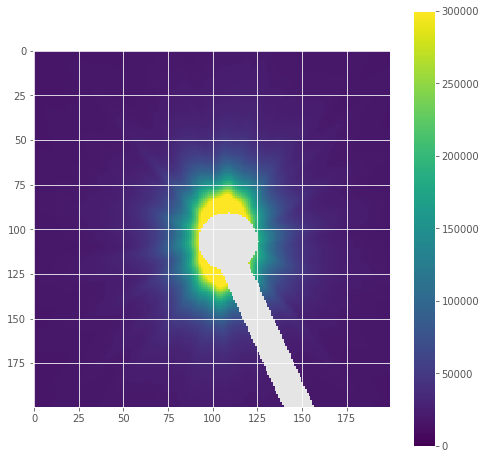

In [17]:
plt.figure(figsize = [8,8])
modelData = dict()
modelData["Q"] = measData["QOrig"]
modelData["I"] = measData["IOrig"]
bArr = np.invert((np.isinf(measData["IOrig"])|(measData["ISigmaOrig"] == 0)))
modelData["I"][bArr] = mc._opt.modelI
modelData["I"] = modelData["I"].reshape(measData["kansas"])
plt.imshow((modelData["I"] * mc._opt.x0[0] + mc._opt.x0[1]), vmin = 0, vmax = 3e5)
plt.colorbar()
mc._opt.x0[1]

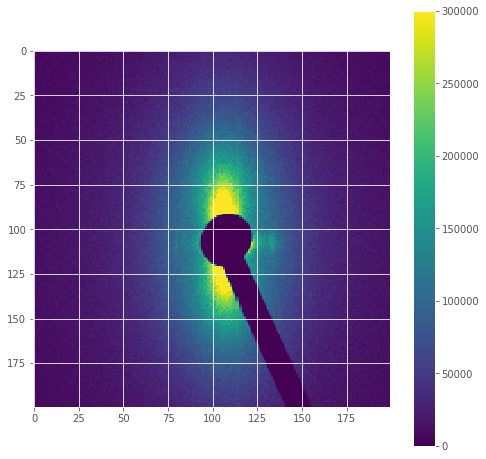

In [18]:
plt.figure(figsize = [8,8])
plt.imshow(I[a0l: a0h, a1l: a1h], vmin = 0, vmax = 3e5)
plt.colorbar()

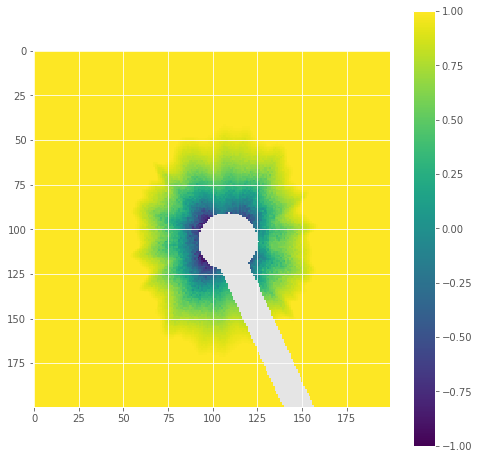

In [19]:
plt.figure(figsize = [8,8])
plt.imshow((I[a0l: a0h, a1l: a1h] - modelData["I"] * mc._opt.x0[0] + mc._opt.x0[1])/I[a0l: a0h, a1l: a1h], vmin = -1, vmax = 1)
plt.colorbar()

(array([20., 15., 12., 19., 10., 19., 18., 27., 28., 19., 16., 17., 17.,
        21., 22., 19., 23., 27., 18., 29., 21., 25., 18., 16., 32., 16.,
        17., 18., 18., 23.]),
 array([ 309.93836907,  399.2417776 ,  488.54518613,  577.84859467,
         667.1520032 ,  756.45541173,  845.75882027,  935.0622288 ,
        1024.36563733, 1113.66904587, 1202.9724544 , 1292.27586293,
        1381.57927147, 1470.88268   , 1560.18608853, 1649.48949707,
        1738.7929056 , 1828.09631413, 1917.39972266, 2006.7031312 ,
        2096.00653973, 2185.30994826, 2274.6133568 , 2363.91676533,
        2453.22017386, 2542.5235824 , 2631.82699093, 2721.13039946,
        2810.433808  , 2899.73721653, 2989.04062506]),
 <a list of 30 Patch objects>)

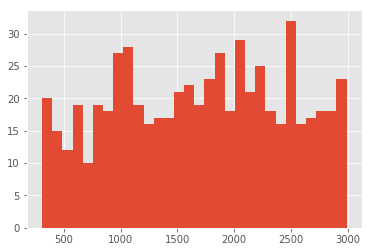

In [20]:
plt.hist(list(mc._model.parameterSet.radius_polar.values), bins = 30)

In [21]:
mc._opt.convCrit

1

In [22]:
mc._OSB.match(mc._opt.modelI, [1, 1])

(array([1.34515307e+01, 1.75222234e+04]), 20.94112966244663)

In [23]:
plt.imshow((mc._OSB.measDataISigma==0).reshape(measData["kansas"]))

ValueError: cannot reshape array of size 37840 into shape (200,200)

In [24]:
plt.imshow(mc._opt.modelI.reshape(measData["kansas"]))

ValueError: cannot reshape array of size 37840 into shape (200,200)

In [555]:
# plt.imshow(mc._opt.modelI.reshape(measData["kansas"]))
mc._opt.testX0

array([1., 0.])

In [314]:
%%timeit
sasmodels.direct_model.call_kernel(kernel, dict(radius=3.1416, background = 0))

1.17 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [315]:
%%timeit
mc.reEvaluate()

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


240 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
t = time.time()
for n in range(10):
    mc.iterate()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("Iterate: {} s".format(time.time() - t))


/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


mc.chisqr: nan, n accepted: 0
Iterate: 2.524678945541382 s


In [316]:
mc._opt.x0

array([ 6968.98184328, 44215.46436466])

In [300]:
t = time.time()
mc.optimize()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("optimization: {} s".format(time.time() - t))



Optimization started
chiSqr: nan, N accepted: 0 / 11


TypeError: '<' not supported between instances of 'int' and 'NoneType'

Other trials
-- 
Generation of a 2D intensity...

{'scale': 1, 'background': 0.001, 'sld': 4, 'sld_solvent': 1, 'radius_polar': 20, 'radius_equatorial': 400, 'theta': 60, 'phi': 60, 'up:frac_i': 0.0, 'up:frac_f': 0.0, 'up:angle': 0.0, 'M0:sld': 0.0, 'mtheta:sld': 0.0, 'mphi:sld': 0.0, 'M0:sld_solvent': 0.0, 'mtheta:sld_solvent': 0.0, 'mphi:sld_solvent': 0.0}
{'scale': 1, 'background': 0.001, 'sld': 4, 'sld_solvent': 1, 'radius_polar': 15, 'radius_equatorial': 400, 'theta': 60, 'phi': 60, 'up:frac_i': 0.0, 'up:frac_f': 0.0, 'up:angle': 0.0, 'M0:sld': 0.0, 'mtheta:sld': 0.0, 'mphi:sld': 0.0, 'M0:sld_solvent': 0.0, 'mtheta:sld_solvent': 0.0, 'mphi:sld_solvent': 0.0}
q2x.shape: (240000,), q2z.shape: (240000,)


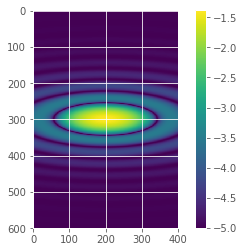

In [143]:
# documentation example on how to calculate a 2D pattern:

model = sasmodels.core.load_model('ellipsoid')
print("{}".format(model.info.parameters.defaults))
model.info.parameters.defaults.update({"radius_polar": 15})
print("{}".format(model.info.parameters.defaults))
qx = np.linspace(-2, 2, 400) # linear
qz = np.linspace(-3, 3, 600) # linear 
q2x = qx + 0 * qz[:, np.newaxis] # make rectangular
q2z = qz[:, np.newaxis] + 0 * qx # make rectangular
kansas = q2x.shape # save original shape
q2x = q2x.reshape(q2x.size) # flatten
q2z = q2z.reshape(q2z.size) # flatten
print("q2x.shape: {}, q2z.shape: {}".format(q2x.shape, q2z.shape))
kernel = model.make_kernel([q2x, q2z]) # feed to kernel
# theta is perpendicularity of cylinder with the beam
# phi = 90, cylinder is "vertical"
Iq = sasmodels.direct_model.call_kernel(kernel, dict(
    radius_equatorial=3.1416, radius_polar = 10, background = 1e-5, theta = 90,
    phi = 90, sld = 1, sld_solvent = 0, 
))
Iq = Iq.reshape(kansas) # move back to original shape
plt.imshow(np.log10(Iq)) # plot
plt.colorbar() 
model.release() # free up space in (GPU) memory

Test of normal least-squares optimization:
--

In [669]:
qs = pandas.read_csv("quickstartdemo1.csv", delimiter = ';', header = None, names = ["Q", "I", "ISigma"])
measData = qs.to_dict(orient = "list")
measData["Q"] = [np.array(measData["Q"])]

measData["I"] = np.array(measData["I"])
measData["ISigma"] = np.array(measData["ISigma"])

model = sasmodels.core.load_model('sphere', dtype = "fast")
kernel = model.make_kernel(measData["Q"])

mcpar = McModel(
    func = model, 
    fitParameterLimits = {"radius": (3, 315)}, 
    staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })

def optFunc(x, kernel, measDataI, measDataISigma):
    # apply positive bounds to scaling and radius
    x[0], x[2] = np.abs(x[0]), np.abs(x[2])
    modelI = sasmodels.direct_model.call_kernel(
                kernel, 
        {'scale': x[0], 'background': x[1], 'radius': x[2]}
    )
    cs = sum(
        ((measDataI - modelI)/measDataISigma)**2
    ) / measDataI.size
    return cs

opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Nelder-Mead",
                        args = (kernel, measData["I"], measData["ISigma"]),)
                        # bounds = [(0, None), 
                        #           (0, None), (0, None)])



In [670]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Powell",
                        args = (kernel, measData["I"], measData["ISigma"]),)

41.8 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [671]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Nelder-Mead",
                        args = (kernel, measData["I"], measData["ISigma"]),)

82.6 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [672]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "CG",
                        args = (kernel, measData["I"], measData["ISigma"]),)

1.34 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [673]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "BFGS",
                        args = (kernel, measData["I"], measData["ISigma"]),)

1.32 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [674]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "TNC",
                        args = (kernel, measData["I"], measData["ISigma"]),)

2.83 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [675]:
opt

 final_simplex: (array([[3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01]]), array([3313.45435733, 3313.45435733, 3313.45435733, 3313.45435733]))
           fun: 3313.4543573342135
       message: 'Optimization terminated successfully.'
          nfev: 300
           nit: 128
        status: 0
       success: True
             x: array([3.19382903e+06, 9.27543685e-01, 7.22338484e+01])

In [676]:
modelI = sasmodels.direct_model.call_kernel(
                kernel, 
        {'scale': opt.x[0], 'background': opt.x[1], 'radius': opt.x[2]}
    )

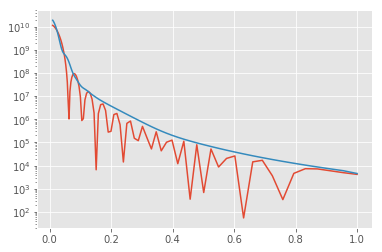

In [677]:
plt.plot(measData["Q"][0], modelI)
plt.plot(measData["Q"][0], measData["I"])
plt.yscale("log")

In [678]:
model.info.parameters.defaults

{'scale': 1,
 'background': 0.001,
 'sld': 1,
 'sld_solvent': 6,
 'radius': 50,
 'up:frac_i': 0.0,
 'up:frac_f': 0.0,
 'up:angle': 0.0,
 'M0:sld': 0.0,
 'mtheta:sld': 0.0,
 'mphi:sld': 0.0,
 'M0:sld_solvent': 0.0,
 'mtheta:sld_solvent': 0.0,
 'mphi:sld_solvent': 0.0}